# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [195]:
import sys

!"{sys.executable}" -m pip install https://github.com/pandas-profiling/pandas-profiling/archive/refs/tags/v3.0.0.zip
!jupyter nbextension enable --py widgetsnbextension
!"{sys.executable}" -m pip install panel

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/refs/tags/v3.0.0.zip
  Preparing metadata (setup.py) ... done
Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# 0. Load all required packages and setup some settings

In [196]:
%load_ext autoreload
%autoreload 2

# Our package
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
import pandas as pd
import numpy as np
import math
import json
import pandas
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data Loading and Exploratory Data Analysis (EDA)

## 1.1 Portfolio Dataset

In [197]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [198]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [199]:
print (f"portfolio: -> {portfolio.shape[0]} rows \n {' '*8}  ->  {portfolio.shape[1]} columns")

portfolio: -> 10 rows 
           ->  6 columns


In [200]:
# creating a more representative column for the channels column, only for the eda part
portfolio['channels_eda'] = portfolio['channels'].apply(lambda x: ' '.join(x))
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id             channels_eda  
0  ae264e3637204a6fb9bb56bc8210ddfd      email mobile social  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  web email mobile social  
2  3f207df678b143eea3cee63160fa8bed         web email mobile  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9         web email mobile  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7                web email  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  web email mobile social  
6  fafdcd668e3743c1bb461111dcafc2a4  web email mobile social  
7  5a8bc65990b245e5a138643cd4eb9837      email mobile social  
8  f19421c1d4aa40978ebb69ca19b0e20d  web email mobile social  
9  2906b810c7d4411798c6938adc9daaa5         web email mobile

In [201]:
display(portfolio.describe(include='all'))
print ()
display(portfolio.info())

reward                      channels  difficulty   duration  \
count   10.000000                            10   10.000000  10.000000   
unique        NaN                             4         NaN        NaN   
top           NaN  [web, email, mobile, social]         NaN        NaN   
freq          NaN                             4         NaN        NaN   
mean     4.200000                           NaN    7.700000   6.500000   
std      3.583915                           NaN    5.831905   2.321398   
min      0.000000                           NaN    0.000000   3.000000   
25%      2.000000                           NaN    5.000000   5.000000   
50%      4.000000                           NaN    8.500000   7.000000   
75%      5.000000                           NaN   10.000000   7.000000   
max     10.000000                           NaN   20.000000  10.000000   

       offer_type                                id             channels_eda  
count          10                                10                       10  
unique          3                                10                        4  
top      discount  5a8bc65990b245e5a138643cd4eb9837  web email mobile social  
freq            4                                 1                        4  
mean          NaN                               NaN                      NaN  
std           NaN                               NaN                      NaN  
min           NaN                               NaN                      NaN  
25%           NaN                               NaN                      NaN  
50%           NaN                               NaN                      NaN  
75%           NaN                               NaN                      NaN  
max           NaN                               NaN                      NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reward        10 non-null     int64 
 1   channels      10 non-null     object
 2   difficulty    10 non-null     int64 
 3   duration      10 non-null     int64 
 4   offer_type    10 non-null     object
 5   id            10 non-null     object
 6   channels_eda  10 non-null     object
dtypes: int64(3), object(4)
memory usage: 688.0+ bytes


None

In [202]:
portfolio_report = ProfileReport(
    portfolio.loc[:, portfolio.columns != 'id']
    , title="Portfolio Exploratory Data Analysis Report"
    , html={"style": {"full_width": True}}
    , explorative=True
    , sort=None
)
portfolio_report.to_file("portfolio_report.html")

portfolio_report

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [203]:
# remove channels_eda column which has been created only for the eda part
portfolio = portfolio.drop(['channels_eda'], axis=1)

## 1.2 Profile Dataset

In [204]:
# read in the json files
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [205]:
profile

gender  age                                id  became_member_on  \
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1          F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3          F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804   
...      ...  ...                               ...               ...   
16995      F   45  6d5f3a774f3d4714ab0c092238f3a1d7          20180604   
16996      M   61  2cb4f97358b841b9a9773a7aa05a9d77          20180713   
16997      M   49  01d26f638c274aa0b965d24cefe3183f          20170126   
16998      F   83  9dc1421481194dcd9400aec7c9ae6366          20160307   
16999      F   62  e4052622e5ba45a8b96b59aba68cf068          20170722   

         income  
0           NaN  
1      112000.0  
2           NaN  
3      100000.0  
4           NaN  
...         ...  
16995   54000.0  
16996   72000.0  
16997   73000.0  
16998   50000.0  
16999   82000.0  

[17000 rows x 5 columns]

In [206]:
print (f"profile: -> {profile.shape[0]} rows \n {' '*6}  ->      {profile.shape[1]} columns")

profile: -> 17000 rows 
         ->      5 columns


In [207]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [208]:
# change became_member_on to date format
profile["became_member_on"] = profile["became_member_on"].apply(lambda x: pd.to_datetime(str(x)))
display(profile.dtypes)
print()
profile

gender                      object
age                          int64
id                          object
became_member_on    datetime64[ns]
income                     float64
dtype: object

gender  age                                id became_member_on    income
0       None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12       NaN
1          F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0
2       None  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12       NaN
3          F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0
4       None  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04       NaN
...      ...  ...                               ...              ...       ...
16995      F   45  6d5f3a774f3d4714ab0c092238f3a1d7       2018-06-04   54000.0
16996      M   61  2cb4f97358b841b9a9773a7aa05a9d77       2018-07-13   72000.0
16997      M   49  01d26f638c274aa0b965d24cefe3183f       2017-01-26   73000.0
16998      F   83  9dc1421481194dcd9400aec7c9ae6366       2016-03-07   50000.0
16999      F   62  e4052622e5ba45a8b96b59aba68cf068       2017-07-22   82000.0

[17000 rows x 5 columns]

In [209]:
display(profile.describe(include='all'))
print ()
display(profile.info())

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  if __name__ == '__main__':


gender           age                                id  \
count   14825  17000.000000                             17000   
unique      3           NaN                             17000   
top         M           NaN  8513fc703ac44ea8816648e2b378b524   
freq     8484           NaN                                 1   
first     NaN           NaN                               NaN   
last      NaN           NaN                               NaN   
mean      NaN     62.531412                               NaN   
std       NaN     26.738580                               NaN   
min       NaN     18.000000                               NaN   
25%       NaN     45.000000                               NaN   
50%       NaN     58.000000                               NaN   
75%       NaN     73.000000                               NaN   
max       NaN    118.000000                               NaN   

           became_member_on         income  
count                 17000   14825.000000  
unique                 1716            NaN  
top     2017-12-07 00:00:00            NaN  
freq                     43            NaN  
first   2013-07-29 00:00:00            NaN  
last    2018-07-26 00:00:00            NaN  
mean                    NaN   65404.991568  
std                     NaN   21598.299410  
min                     NaN   30000.000000  
25%                     NaN   49000.000000  
50%                     NaN   64000.000000  
75%                     NaN   80000.000000  
max                     NaN  120000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


None

In [210]:
profile_report = ProfileReport(profile.loc[:, profile.columns != 'id'], title="Profile Exploratory Data Analysis Report", explorative=True)
profile_report.to_file("profile_report.html")

profile_report

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 1.3 Transcript Dataset

In [211]:
# read in the json files
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [212]:
transcript

person           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  time  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4       {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
...                                                  ...   ...  
306529                    {'amount': 1.5899999999999999}   714  
306530                                  {'amount': 9.53}   714  
306531                                  {'amount': 3.61}   714  
306532                    {'amount': 3.5300000000000002}   714  
306533                                  {'amount': 4.05}   714  

[306534 rows x 4 columns]

In [213]:
print (f"transcript: -> {transcript.shape[0]} rows \n {' '*9}  ->      {transcript.shape[1]} columns")

transcript: -> 306534 rows 
            ->      4 columns


In [214]:
transcript['value_eda'] = transcript.value.apply(lambda x: json.dumps(x).replace(x['offer id'], portfolio.offer_type[portfolio.id==x['offer id']].values[0]) if 'offer id' in x.keys() else json.dumps(x))
transcript

person           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  time  \
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4       {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   
...                                                  ...   ...   
306529                    {'amount': 1.5899999999999999}   714   
306530                                  {'amount': 9.53}   714   
306531                                  {'amount': 3.61}   714   
306532                    {'amount': 3.5300000000000002}   714   
306533                                  {'amount': 4.05}   714   

                             value_eda  
0                 {"offer id": "bogo"}  
1             {"offer id": "discount"}  
2             {"offer id": "discount"}  
3             {"offer id": "discount"}  
4                 {"offer id": "bogo"}  
...                                ...  
306529  {"amount": 1.5899999999999999}  
306530                {"amount": 9.53}  
306531                {"amount": 3.61}  
306532  {"amount": 3.5300000000000002}  
306533                {"amount": 4.05}  

[306534 rows x 5 columns]

In [215]:
display(transcript.describe(include='all'))
print ()
display(transcript.info())

person        event  \
count                             306534       306534   
unique                             17000            4   
top     94de646f7b6041228ca7dec82adb97d2  transaction   
freq                                  51       138953   
mean                                 NaN          NaN   
std                                  NaN          NaN   
min                                  NaN          NaN   
25%                                  NaN          NaN   
50%                                  NaN          NaN   
75%                                  NaN          NaN   
max                                  NaN          NaN   

                                                   value           time  \
count                                             306534  306534.000000   
unique                                              5121            NaN   
top     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}            NaN   
freq                                               14983            NaN   
mean                                                 NaN     366.382940   
std                                                  NaN     200.326314   
min                                                  NaN       0.000000   
25%                                                  NaN     186.000000   
50%                                                  NaN     408.000000   
75%                                                  NaN     528.000000   
max                                                  NaN     714.000000   

                   value_eda  
count                 306534  
unique                  5114  
top     {"offer id": "bogo"}  
freq                   55948  
mean                     NaN  
std                      NaN  
min                      NaN  
25%                      NaN  
50%                      NaN  
75%                      NaN  
max                      NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person     306534 non-null  object
 1   event      306534 non-null  object
 2   value      306534 non-null  object
 3   time       306534 non-null  int64 
 4   value_eda  306534 non-null  object
dtypes: int64(1), object(4)
memory usage: 11.7+ MB


None

In [216]:
transcript_report = ProfileReport(transcript.loc[:, transcript.columns != 'value'], title="Transcript Exploratory Data Analysis Report", explorative=True)
transcript_report.to_file("transcript_report.html")

transcript_report

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Data Cleaning / Transformation

## 2.1 Cleaning & Transforming Portfolio Dataset
Looking at the exploratory data analysis of the portfolio dataset at the section 1.1:
- No actual need of cleaning the values of any of the columns (there are no null values or any outliers)
- Need to rename the existing column names to more representative feature names which will be used later on in the final dataframe
 - `id -> offer_id`
 - `reward -> offer_reward`
 - `duration -> offer_duration_days`
 - `difficulty -> offer_difficulty`
- One hot encode the `channels` columns
- Remove the `offer_type` and `channels` columns and replace them with their corresponding one hot encoded values

In [217]:
def clean_transform_portfolio(portfolio):
    """
    Function to clean and transform the portfolio  
    dataframe based on above requirements    
    
    Parameters 
        portfolio: portfolio dataframe
    
    Returns
        portfolio_cleaned: the cleaned portfolio dataframe
    """
    
    # rename columns
    portfolio = portfolio.rename(columns = {'id':'offer_id', 
                                            'reward':'offer_reward', 
                                            'duration':'offer_duration_days', 
                                            'difficulty':'offer_difficulty'})
    
    # one hot encode channels
    multi_label_binarizer = MultiLabelBinarizer()
    multi_label_binarizer.fit(portfolio['channels'])
    
    channels_encoded = pd.DataFrame(
        multi_label_binarizer.transform(portfolio['channels']), 
        columns=multi_label_binarizer.classes_)
    
    # remove offer_type and channels columns
    portfolio = portfolio.drop(['channels'], axis=1) 
    
    # create final portfolio_cleaned dataframe by adding the encoded columns
    portfolio_cleaned = pd.concat([portfolio, channels_encoded], axis=1) 
    
    # put all columns in a more representative order
    columns_order = ['offer_id', 'offer_type', 'offer_duration_days', 'offer_difficulty',
                     'offer_reward', 'email', 'mobile', 'social', 'web']
    
    return portfolio_cleaned[columns_order]

In [218]:
portfolio_cleaned = clean_transform_portfolio(portfolio)
portfolio_cleaned

offer_id     offer_type  offer_duration_days  \
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo                    7   
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo                    5   
2  3f207df678b143eea3cee63160fa8bed  informational                    4   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo                    7   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount                   10   
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount                    7   
6  fafdcd668e3743c1bb461111dcafc2a4       discount                   10   
7  5a8bc65990b245e5a138643cd4eb9837  informational                    3   
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo                    5   
9  2906b810c7d4411798c6938adc9daaa5       discount                    7   

   offer_difficulty  offer_reward  email  mobile  social  web  
0                10            10      1       1       1    0  
1                10            10      1       1       1    1  
2                 0             0      1       1       0    1  
3                 5             5      1       1       0    1  
4                20             5      1       0       0    1  
5                 7             3      1       1       1    1  
6                10             2      1       1       1    1  
7                 0             0      1       1       1    0  
8                 5             5      1       1       1    1  
9                10             2      1       1       0    1

## 2.2 Cleaning & Transforming Profile Dataset
Looking at the exploratory data analysis of the profile dataset at the section 1.2:
- There are no extreme values for any of the columns. However, there are approximately 12.8% of missing values which should be removed
- Extract only the year information from the `became_member_on` column
- Need to rename the existing column names to more representative feature names which will be used later on in the final dataframe
 - `id -> customer_id`
 - `age -> customer_age`
 - `became_member_on -> customer_registration_year`
 - `income -> customer_income`

In [219]:
print ('Any NULL value on any row in the profile dataset is equal to:', round((1- (profile.dropna().shape[0]/profile.shape[0])), 3)*100, '%')
print ('Number of customers with 118 age and missing values in general', round(profile['income'][profile.age==118].shape[0]/profile.shape[0], 3)*100, '%')

Any NULL value on any row in the profile dataset is equal to: 12.8 %
Number of customers with 118 age and missing values in general 12.8 %


In [220]:
def clean_transform_profile(profile):
    """
    Function to clean and transform the profile  
    dataframe based on above requirements    
    
    Parameters 
        profile: profile dataframe
    
    Returns
        profile_cleaned: the cleaned profile dataframe
    """
    
    # remove any customer with missing value (12.8% of all customers have a missing value and age assigned as 118)
    profile_cleaned = profile.dropna().reset_index()
    
    # keep only the year that each customer became member
    profile_cleaned['became_member_on'] = pd.DatetimeIndex(profile_cleaned.became_member_on).year
    
    # rename columns
    profile_cleaned = profile_cleaned.rename(columns = {'became_member_on':'customer_registration_year',
                                                        'income':'customer_income',
                                                        'id':'customer_id', 
                                                        'age':'customer_age',
                                                        'gender':'customer_gender'})
    
    # put all columns in a more representative order
    columns_order = ['customer_id', 'customer_age', 'customer_gender', 
                     'customer_income', 'customer_registration_year']
    
    return profile_cleaned[columns_order]

In [221]:
profile_cleaned = clean_transform_profile(profile)
profile_cleaned

customer_id  customer_age customer_gender  \
0      0610b486422d4921ae7d2bf64640c50b            55               F   
1      78afa995795e4d85b5d9ceeca43f5fef            75               F   
2      e2127556f4f64592b11af22de27a7932            68               M   
3      389bc3fa690240e798340f5a15918d5c            65               M   
4      2eeac8d8feae4a8cad5a6af0499a211d            58               M   
...                                 ...           ...             ...   
14820  6d5f3a774f3d4714ab0c092238f3a1d7            45               F   
14821  2cb4f97358b841b9a9773a7aa05a9d77            61               M   
14822  01d26f638c274aa0b965d24cefe3183f            49               M   
14823  9dc1421481194dcd9400aec7c9ae6366            83               F   
14824  e4052622e5ba45a8b96b59aba68cf068            62               F   

       customer_income  customer_registration_year  
0             112000.0                        2017  
1             100000.0                        2017  
2              70000.0                        2018  
3              53000.0                        2018  
4              51000.0                        2017  
...                ...                         ...  
14820          54000.0                        2018  
14821          72000.0                        2018  
14822          73000.0                        2017  
14823          50000.0                        2016  
14824          82000.0                        2017  

[14825 rows x 5 columns]

## 2.3 Cleaning & Transforming Transcript Dataset

### 2.3.1 Cleaning Transcript Dataset
Looking at the exploratory data analysis of the profile dataset at the section 1.3:
- No actual need of cleaning the values of any of the columns (there are no null values or any outliers)
- Need to remove value_eda created in step 1.3
- Need to rename key values in value column from `offer id` to `offer_id` for any instance that this is true
- Need to remove any customer that is not appear in the profile dataset
- Need to rename the existing column names to more representative feature names which will be used later on in the final dataframe
 - `person'-> customer_id`
 - `time -> time_hours`

In [222]:
def clean_transcript(transcript, profile):
    """
    Function to clean  the transcript dataframe  
    based on above requirements    
    
    Parameters 
        transcript: transcript dataframe
        profile: cleaned profile dataframe
    
    Returns
        transcript_cleaned: the cleaned transcript dataframe
    """
    
    # remove value_eda column
    transcript = transcript.drop(['value_eda'], axis=1)
    
    # rename offer id to offer_id if applicable 
    transcript['value'] = transcript.value.apply(lambda x: {'offer_id': x['offer id']} if 'offer id' in x.keys() and 'reward' not in x.keys() else x)   
    
    # remove any customer that is not appear in the profile dataset
    all_customers_list = list(profile['customer_id'])
    transcript = transcript[transcript.person.apply(lambda x: x in all_customers_list)].reset_index()
    
    # rename columns
    transcript_cleaned = transcript.rename(columns = {'person':'customer_id',
                                                      'time':'time_hours',})

    # put all columns in a more representative order
    columns_order = ['customer_id', 'event', 'value', 'time_hours']
    
    return transcript_cleaned[columns_order]

In [223]:
transcript_cleaned = clean_transcript(transcript, profile_cleaned)
transcript_cleaned

customer_id            event  \
0       78afa995795e4d85b5d9ceeca43f5fef   offer received   
1       e2127556f4f64592b11af22de27a7932   offer received   
2       389bc3fa690240e798340f5a15918d5c   offer received   
3       2eeac8d8feae4a8cad5a6af0499a211d   offer received   
4       aa4862eba776480b8bb9c68455b8c2e1   offer received   
...                                  ...              ...   
272757  24f56b5e1849462093931b164eb803b5  offer completed   
272758  b3a1272bc9904337b331bf348c3e8c17      transaction   
272759  68213b08d99a4ae1b0dcb72aebd9aa35      transaction   
272760  a00058cf10334a308c68e7631c529907      transaction   
272761  76ddbd6576844afe811f1a3c0fbb5bec      transaction   

                                                                value  \
0                    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   
1                    {'offer_id': '2906b810c7d4411798c6938adc9daaa5'}   
2                    {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   
3                    {'offer_id': '3f207df678b143eea3cee63160fa8bed'}   
4                    {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   
...                                                               ...   
272757  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}   
272758                                 {'amount': 1.5899999999999999}   
272759                                               {'amount': 9.53}   
272760                                               {'amount': 3.61}   
272761                                 {'amount': 3.5300000000000002}   

        time_hours  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
272757         714  
272758         714  
272759         714  
272760         714  
272761         714  

[272762 rows x 4 columns]

### 2.3.2 Transforming Transcript Dataset
This is a really important step as the **label** of our dataset will be created. <br />
The label will be named `successful_offer` and it will be a binary feature with values 0 or 1. These values will represent if an offer was a successful offer, from the company's perspective, for this customer or not. <br /> <br />
An successful offer is the offer which follows the below steps:
- `Offer Received` -> `Offer Viewed` -> `Offer Completed`

In [224]:
def offer_summary(transcript, portfolio):
    """
    Function to create a summary of all offers for each customer which will present  
    which offer was successful for each customer based on the above logic    
    
    Parameters 
        transcript: cleaned transcript dataframe
        portfolio: cleaned portfolio dataframe
    
    Returns
        offer_summary: a dataframe with customer_id, offer_id and corresponding label
    """
    
    offer_received = transcript_cleaned.query("event=='offer received'").reset_index(drop=True)
    offer_received.value = offer_received.value.apply(lambda x: x['offer_id'])

    offer_viewed = transcript_cleaned.query("event=='offer viewed'").reset_index(drop=True)
    offer_viewed.value = offer_viewed.value.apply(lambda x: x['offer_id'])

    offer_completed = transcript_cleaned.query("event=='offer completed'").reset_index(drop=True)
    offer_completed.value = offer_completed.value.apply(lambda x: x['offer_id'])
    
    offer_summary_list = list()
    for index, received_row in offer_received.iterrows():
        received_customer_id = received_row.customer_id
        received_offer_id = received_row.value
        received_time_hours = received_row.time_hours
        offer_duration_hours = (portfolio_cleaned.query(f"offer_id=='{received_offer_id}'").offer_duration_days).values[0]*24

        viewed_df = offer_viewed.query(f"time_hours>={received_time_hours} & time_hours<={received_time_hours+offer_duration_hours} & value=='{received_offer_id}' & customer_id=='{received_customer_id}'")

        if not viewed_df.empty:
            viewed_time_hours = viewed_df.iloc[0].time_hours

            completed_df = offer_completed.query(f"time_hours>={viewed_time_hours} & time_hours<={received_time_hours+offer_duration_hours} & value=='{received_offer_id}' & customer_id=='{received_customer_id}'")
            if not completed_df.empty:            
                successful_offer = 1
        else:
            successful_offer = 0

        offer_summary_list.append([received_customer_id, received_offer_id, successful_offer])

    return pd.DataFrame(offer_summary_list, columns=['customer_id', 'offer_id', 'successful_offer'])

In [225]:
# offer_summary = offer_summary(transcript_cleaned, portfolio_cleaned)
# offer_summary.to_csv('offer_summary.csv', index=False)
# offer_summary

In [226]:
offer_summary = pd.read_csv('offer_summary.csv')
offer_summary

customer_id                          offer_id  \
0      78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1      e2127556f4f64592b11af22de27a7932  2906b810c7d4411798c6938adc9daaa5   
2      389bc3fa690240e798340f5a15918d5c  f19421c1d4aa40978ebb69ca19b0e20d   
3      2eeac8d8feae4a8cad5a6af0499a211d  3f207df678b143eea3cee63160fa8bed   
4      aa4862eba776480b8bb9c68455b8c2e1  0b1e1539f2cc45b7b9fa7c272da2e1d7   
...                                 ...                               ...   
66496  d087c473b4d247ccb0abfef59ba12b0e  ae264e3637204a6fb9bb56bc8210ddfd   
66497  cb23b66c56f64b109d673d5e56574529  2906b810c7d4411798c6938adc9daaa5   
66498  6d5f3a774f3d4714ab0c092238f3a1d7  2298d6c36e964ae4a3e7e9706d1fb8c2   
66499  9dc1421481194dcd9400aec7c9ae6366  ae264e3637204a6fb9bb56bc8210ddfd   
66500  e4052622e5ba45a8b96b59aba68cf068  3f207df678b143eea3cee63160fa8bed   

       successful_offer  
0                     1  
1                     1  
2                     1  
3                     0  
4                     0  
...                 ...  
66496                 1  
66497                 0  
66498                 0  
66499                 0  
66500                 0  

[66501 rows x 3 columns]

## 2.4 Data Merge / Final Dataframe

In [227]:
def data_merge(portfolio, profile, offer_summary):
    """
    Creation of the final table by merging
    the final cleaned data frames
       
    Parameters
    ---------- 
    portfolio : cleaned and transformed portfolio data frame
    profile : cleaned and transformed profile data frame
    offer_summary : final offer_summary table as defined above
      
    Returns
    -------
    merged_df: merged data frame to be used in our problem
    
    """
    
    merged_df = pd.merge(offer_summary, profile, on='customer_id')
    merged_df = pd.merge(merged_df, portfolio, on='offer_id')
    
    columns_order = ['customer_age', 'customer_gender', 'customer_income', 'customer_registration_year',
                     'offer_type', 'offer_duration_days', 'offer_difficulty', 'offer_reward',
                     'email', 'mobile', 'social', 'web', 'successful_offer']
    
    return merged_df[columns_order]

In [228]:
merged_df = data_merge(portfolio_cleaned, profile_cleaned, offer_summary)
merged_df

customer_age customer_gender  customer_income  \
0                75               F         100000.0   
1                68               M          70000.0   
2                65               M          53000.0   
3                65               M          53000.0   
4                56               F          88000.0   
...             ...             ...              ...   
66496            48               M          58000.0   
66497            44               F          81000.0   
66498            47               M          94000.0   
66499            61               F          60000.0   
66500            58               F          78000.0   

       customer_registration_year offer_type  offer_duration_days  \
0                            2017       bogo                    7   
1                            2018       bogo                    7   
2                            2018       bogo                    7   
3                            2018       bogo                    7   
4                            2018       bogo                    7   
...                           ...        ...                  ...   
66496                        2018       bogo                    5   
66497                        2016       bogo                    5   
66498                        2017       bogo                    5   
66499                        2014       bogo                    5   
66500                        2016       bogo                    5   

       offer_difficulty  offer_reward  email  mobile  social  web  \
0                     5             5      1       1       0    1   
1                     5             5      1       1       0    1   
2                     5             5      1       1       0    1   
3                     5             5      1       1       0    1   
4                     5             5      1       1       0    1   
...                 ...           ...    ...     ...     ...  ...   
66496                10            10      1       1       1    1   
66497                10            10      1       1       1    1   
66498                10            10      1       1       1    1   
66499                10            10      1       1       1    1   
66500                10            10      1       1       1    1   

       successful_offer  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
...                 ...  
66496                 1  
66497                 1  
66498                 0  
66499                 1  
66500                 1  

[66501 rows x 13 columns]

# 3. EDA & Feature Engineering on Final Table

## 3.1 Pandas Profiling Report (EDA)

In [229]:
display(merged_df.describe(include='all'))
print ()
display(merged_df.info())

customer_age customer_gender  customer_income  \
count   66501.000000           66501     66501.000000   
unique           NaN               3              NaN   
top              NaN               M              NaN   
freq             NaN           38129              NaN   
mean       54.369258             NaN     65371.618472   
std        17.395430             NaN     21623.288473   
min        18.000000             NaN     30000.000000   
25%        42.000000             NaN     49000.000000   
50%        55.000000             NaN     64000.000000   
75%        66.000000             NaN     80000.000000   
max       101.000000             NaN    120000.000000   

        customer_registration_year offer_type  offer_duration_days  \
count                 66501.000000      66501         66501.000000   
unique                         NaN          3                  NaN   
top                            NaN   discount                  NaN   
freq                           NaN      26664                  NaN   
mean                   2016.622021        NaN             6.507571   
std                       1.198364        NaN             2.204416   
min                    2013.000000        NaN             3.000000   
25%                    2016.000000        NaN             5.000000   
50%                    2017.000000        NaN             7.000000   
75%                    2017.000000        NaN             7.000000   
max                    2018.000000        NaN            10.000000   

        offer_difficulty  offer_reward    email        mobile        social  \
count        66501.00000  66501.000000  66501.0  66501.000000  66501.000000   
unique               NaN           NaN      NaN           NaN           NaN   
top                  NaN           NaN      NaN           NaN           NaN   
freq                 NaN           NaN      NaN           NaN           NaN   
mean             7.71417      4.198824      1.0      0.898859      0.598517   
std              5.54754      3.398100      0.0      0.301518      0.490202   
min              0.00000      0.000000      1.0      0.000000      0.000000   
25%              5.00000      2.000000      1.0      1.000000      0.000000   
50%             10.00000      5.000000      1.0      1.000000      1.000000   
75%             10.00000      5.000000      1.0      1.000000      1.000000   
max             20.00000     10.000000      1.0      1.000000      1.000000   

                 web  successful_offer  
count   66501.000000      66501.000000  
unique           NaN               NaN  
top              NaN               NaN  
freq             NaN               NaN  
mean        0.799612          0.567119  
std         0.400294          0.495478  
min         0.000000          0.000000  
25%         1.000000          0.000000  
50%         1.000000          1.000000  
75%         1.000000          1.000000  
max         1.000000          1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_age                66501 non-null  int64  
 1   customer_gender             66501 non-null  object 
 2   customer_income             66501 non-null  float64
 3   customer_registration_year  66501 non-null  int64  
 4   offer_type                  66501 non-null  object 
 5   offer_duration_days         66501 non-null  int64  
 6   offer_difficulty            66501 non-null  int64  
 7   offer_reward                66501 non-null  int64  
 8   email                       66501 non-null  int64  
 9   mobile                      66501 non-null  int64  
 10  social                      66501 non-null  int64  
 11  web                         66501 non-null  int64  
 12  successful_offer            66501 non-null  int64  
dtypes: float64(1), int64(10), obje

None

In [230]:
merged_df_report = ProfileReport(merged_df, title="Final Table Exploratory Data Analysis Report", explorative=True)
merged_df_report.to_file("merged_df_report.html")

merged_df_report

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas_profiling/model/correlations.py:210: RuntimeWarning: invalid value encountered in greater_equal
  bool_index = abs(correlation_matrix.values) >= threshold


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.2 Manual EDA

In [231]:
merged_df

customer_age customer_gender  customer_income  \
0                75               F         100000.0   
1                68               M          70000.0   
2                65               M          53000.0   
3                65               M          53000.0   
4                56               F          88000.0   
...             ...             ...              ...   
66496            48               M          58000.0   
66497            44               F          81000.0   
66498            47               M          94000.0   
66499            61               F          60000.0   
66500            58               F          78000.0   

       customer_registration_year offer_type  offer_duration_days  \
0                            2017       bogo                    7   
1                            2018       bogo                    7   
2                            2018       bogo                    7   
3                            2018       bogo                    7   
4                            2018       bogo                    7   
...                           ...        ...                  ...   
66496                        2018       bogo                    5   
66497                        2016       bogo                    5   
66498                        2017       bogo                    5   
66499                        2014       bogo                    5   
66500                        2016       bogo                    5   

       offer_difficulty  offer_reward  email  mobile  social  web  \
0                     5             5      1       1       0    1   
1                     5             5      1       1       0    1   
2                     5             5      1       1       0    1   
3                     5             5      1       1       0    1   
4                     5             5      1       1       0    1   
...                 ...           ...    ...     ...     ...  ...   
66496                10            10      1       1       1    1   
66497                10            10      1       1       1    1   
66498                10            10      1       1       1    1   
66499                10            10      1       1       1    1   
66500                10            10      1       1       1    1   

       successful_offer  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
...                 ...  
66496                 1  
66497                 1  
66498                 0  
66499                 1  
66500                 1  

[66501 rows x 13 columns]

### Customer Age & Customer Income

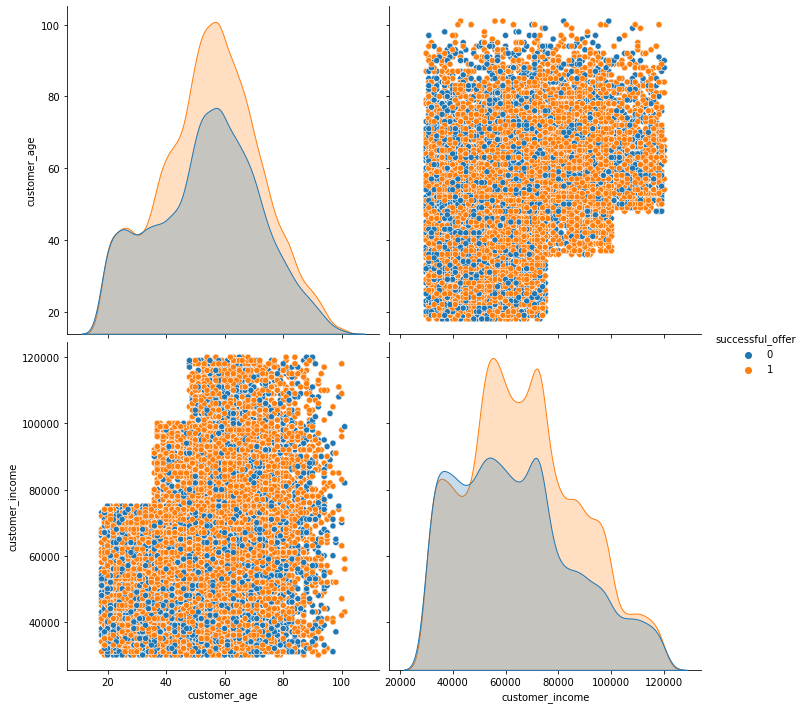

In [232]:
sns.pairplot(merged_df[['customer_age', 'customer_income', 'successful_offer']], hue='successful_offer', height=5)
plt.show()

### Gender

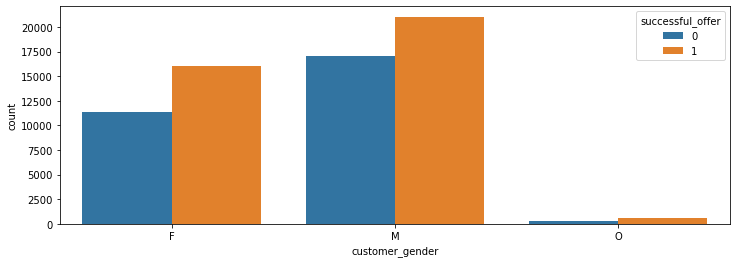

In [233]:
plt.figure(figsize=(12, 4))
sns.countplot(hue="successful_offer", x= "customer_gender", data=merged_df)
plt.show()

### Offer Type

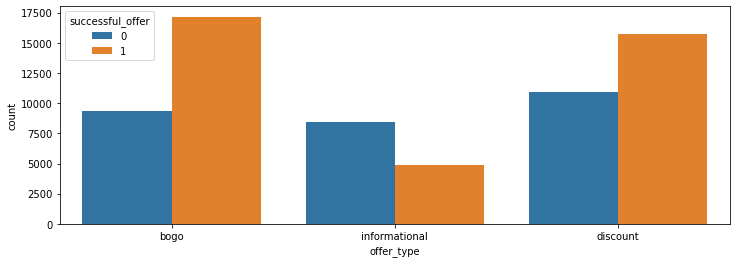

In [234]:
plt.figure(figsize=(12, 4))
sns.countplot(hue="successful_offer", x= "offer_type", data=merged_df)
plt.show()

### Offer Duration

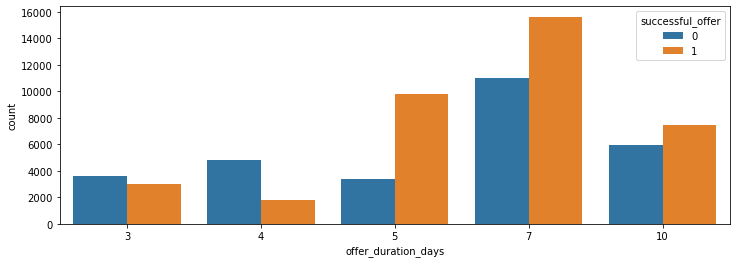

In [235]:
plt.figure(figsize=(12, 4))
sns.countplot(hue="successful_offer", x= "offer_duration_days", data=merged_df)
plt.show()

### Offer Difficulty

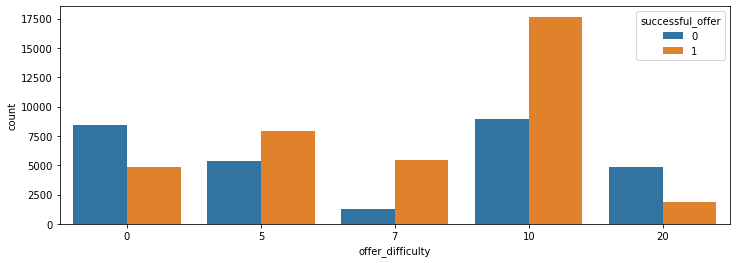

In [236]:
plt.figure(figsize=(12, 4))
sns.countplot(hue="successful_offer", x= "offer_difficulty", data=merged_df)
plt.show()

### Offer Reward

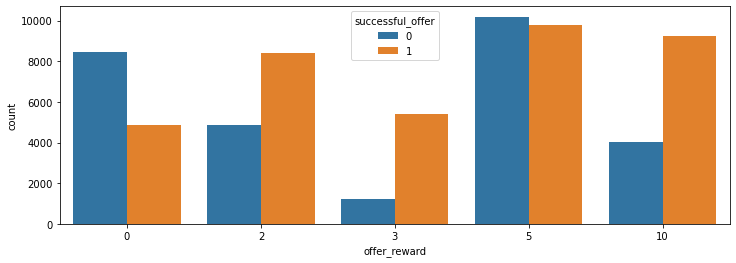

In [237]:
plt.figure(figsize=(12, 4))
sns.countplot(hue="successful_offer", x= "offer_reward", data=merged_df)
plt.show()

### Registration Year

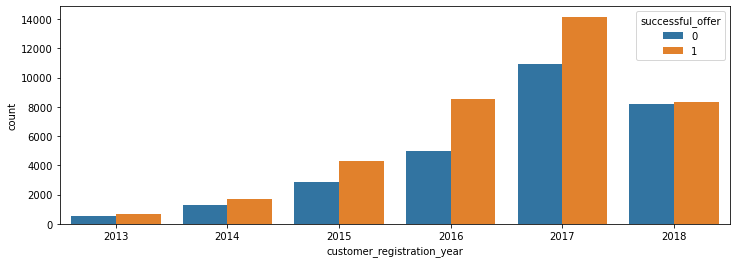

In [238]:
plt.figure(figsize=(12, 4))
sns.countplot(hue="successful_offer", x= "customer_registration_year", data=merged_df)
plt.show()

## 3.3 Feature Cleaning & Engineering based on above results

Looking at the exploratory data analysis of the final dataset above:
- Categorical features:
 - One hot encode `offer_type` column
 - One hot encode `customer_gender` column
 - One hot encode `customer_registration_year` column
- Numerical features:
 - Scale and normalize `customer_age` column
 - Scale and normalize `customer_income` column
 - Scale and normalize `offer_duration_days` column
 - Scale and normalize `offer_difficulty` column
 - Scale and normalize `offer_reward` column
 
- Gender `O` has less than 2% of data and as a result this column should be **dropped** because it does not bring any value to the final model
- Channel `email` appears to all offers, so 100% of its values are constant and as a result this column should be **dropped**
- Gender `M` is highly correlated with gender `F`, so one of the two has to be **dropped**. This is because highly correlated features do not work well in machine learning models and may negatively influence the performance of them
- There are some duplicate rows and should be dropped

In [239]:
def transform_engineer_merged_df(merged_df):
    """
    Function to clean and transform the final   
    dataframe based on above requirements    
    
    Parameters 
        merged_df: the final merged dataframe
        
    Returns
        final_df: the transformed transcript dataframe
    """

    # one hot encode offer_type
    offer_type_encoded = pd.get_dummies(merged_df['offer_type'])
    
    # one hot encode offer_type
    customer_gender_encoded = pd.get_dummies(merged_df['customer_gender'])

    # one hot encode customer_registration_year
    customer_registration_year_encoded = pd.get_dummies(merged_df['customer_registration_year'])
    
    # create final profile_cleaned dataframe by adding the encoded columns
    final_df = pd.concat([merged_df, offer_type_encoded, customer_gender_encoded, customer_registration_year_encoded], axis=1)

    # scale numerical features
    scaler = MinMaxScaler() 
    numerical_features = ['customer_age', 'customer_income', 'offer_duration_days', 'offer_difficulty', 'offer_reward']
    final_df[numerical_features] = scaler.fit_transform(final_df[numerical_features])
    
    # remove the columns based on above requirements and the encoded columns
    final_df = final_df.drop(['offer_type', 'customer_gender', 'customer_registration_year', 'O', 'email', 'F'], axis=1)
    
    # drop duplicates
    final_df = final_df.drop_duplicates().reset_index(drop=True)

    # order the resulted columns
    columns_order = ['customer_age', 'M', 'customer_income'] + list(customer_registration_year_encoded.columns) + \
                    ['bogo', 'discount', 'informational', 'offer_duration_days', 'offer_difficulty', 'offer_reward',
                     'mobile', 'social', 'web', 'successful_offer']
    
    return final_df[columns_order]

In [240]:
final_df = transform_engineer_merged_df(merged_df)
final_df

customer_age  M  customer_income  2013  2014  2015  2016  2017  2018  \
0          0.686747  0         0.777778     0     0     0     0     1     0   
1          0.602410  1         0.444444     0     0     0     0     0     1   
2          0.566265  1         0.255556     0     0     0     0     0     1   
3          0.457831  0         0.644444     0     0     0     0     0     1   
4          0.457831  0         0.644444     0     0     0     0     0     1   
...             ... ..              ...   ...   ...   ...   ...   ...   ...   
55447      0.361446  1         0.311111     0     0     0     0     0     1   
55448      0.313253  0         0.566667     0     0     0     1     0     0   
55449      0.349398  1         0.711111     0     0     0     0     1     0   
55450      0.518072  0         0.333333     0     1     0     0     0     0   
55451      0.481928  0         0.533333     0     0     0     1     0     0   

       bogo  discount  informational  offer_duration_days  offer_difficulty  \
0         1         0              0             0.571429              0.25   
1         1         0              0             0.571429              0.25   
2         1         0              0             0.571429              0.25   
3         1         0              0             0.571429              0.25   
4         1         0              0             0.571429              0.25   
...     ...       ...            ...                  ...               ...   
55447     1         0              0             0.285714              0.50   
55448     1         0              0             0.285714              0.50   
55449     1         0              0             0.285714              0.50   
55450     1         0              0             0.285714              0.50   
55451     1         0              0             0.285714              0.50   

       offer_reward  mobile  social  web  successful_offer  
0               0.5       1       0    1                 1  
1               0.5       1       0    1                 1  
2               0.5       1       0    1                 1  
3               0.5       1       0    1                 1  
4               0.5       1       0    1                 0  
...             ...     ...     ...  ...               ...  
55447           1.0       1       1    1                 1  
55448           1.0       1       1    1                 1  
55449           1.0       1       1    1                 0  
55450           1.0       1       1    1                 1  
55451           1.0       1       1    1                 1  

[55452 rows x 19 columns]

# 4. Prepare and split the data in training and test sets

In [241]:
def train_test_split_bal(df, label):
    """
    Function to split the data in training and test set
    with the option to balance the dataset as well
    
    Parameters 
        df: the final merged dataframe
        label: the target label
        
    Returns
        X_train, X_test, y_train, y_test: the training and test sets
    """
    
    X = df.loc[:, df.columns != label]
    y = df[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    count_0, count_1 = y_train.value_counts()[0], y_train.value_counts()[1]

    if count_1>count_0:
        index_0 = list(y_train[y_train==0].index)
        index_1 = list(y_train[y_train==1].sample(n=count_0, random_state=42).index)
    else:
        index_1 = list(y_train[y_train==1].index)
        index_0 = list(y_train[y_train==0].sample(n=count_1, random_state=42).index)    

    X_train = X_train.loc[index_0+index_1]
    y_train = y_train.loc[index_0+index_1]

    return X_train, X_test, y_train, y_test

In [242]:
X_train, X_test, y_train, y_test = train_test_split_bal(final_df, 'successful_offer')
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33914, 18), (16636, 18), (33914,), (16636,))